# School Boarding Prediction Project


**Goal:** Predict if a school offers boarding (YES or NO)




> Data files are not included in this repository (CSV and SQL Server backup are large).  
> This notebook shows the full pipeline and results using those data sources.

In [13]:
# Core libraries and ML tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Part 1: Load and Understand the Data


In [14]:
# Load the dataset
df = pd.read_csv('fr-en-annuaire-education_with_scores_imputed.csv', low_memory=False)

print("Dataset loaded!")
print(f"Total rows: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")

# Show first few rows
df.head()


Dataset loaded!
Total rows: 68,998
Total columns: 73


,Identifiant_de_l_etablissement,Nom_etablissement,Type_etablissement,Statut_public_prive,Adresse_1,Adresse_2,Adresse_3,Code_postal,Code_commune,Nom_commune,...,Code_type_contrat_prive,PIAL,etablissement_mere,type_rattachement_etablissement_mere,code_circonscription,code_zone_animation_pedagogique,libelle_zone_animation_pedagogique,code_bassin_formation,libelle_bassin_formation,Average_Score_moyen
0,0060174G,Ecole maternelle Bocca Centre,Ecole,Public,33 boulevard Louis NÃ©grin,LA BOCCA,06150 CANNES,6150,06029,Cannes,...,99,0060799L,NaN,NaN,0061350K,NaN,NaN,23066,CANNES GRASSE,280.110408
1,0060179M,Ecole maternelle Jacqueline de Romilly,Ecole,Public,176 avenue de Grasse,NaN,06400 CANNES,6400,06029,Cannes,...,99,0061279H,NaN,NaN,0061350K,NaN,NaN,23066,CANNES GRASSE,280.110408
2,0060200K,Ecole maternelle Les Orangers,Ecole,Public,Rue des Oliviers,NaN,06110 LE CANNET,6110,06030,Le Cannet,...,99,0061239P,NaN,NaN,0061566V,NaN,NaN,23066,CANNES GRASSE,280.110408
3,0060203N,Ecole Ã©lÃ©mentaire Cougoussoles,Ecole,Public,13 allÃ©e Docteur Calmette,NaN,06110 LE CANNET,6110,06030,Le Cannet,...,99,0061239P,NaN,NaN,0061566V,NaN,NaN,23066,CANNES GRASSE,275.802387
4,0060212Y,Ecole primaire de Castagniers,Ecole,Public,52 chemin du Carretier,NaN,06670 CASTAGNIERS,6670,06034,Castagniers,...,99,0061400P,NaN,NaN,0061981W,NaN,NaN,23062,NICE EST,280.110408


Target variable distribution:
Hebergement
0.0    59332
NaN     4985
1.0     4681
Name: count, dtype: int64

YES (has boarding): 4,681
NO (no boarding): 59,332
Missing: 4,985


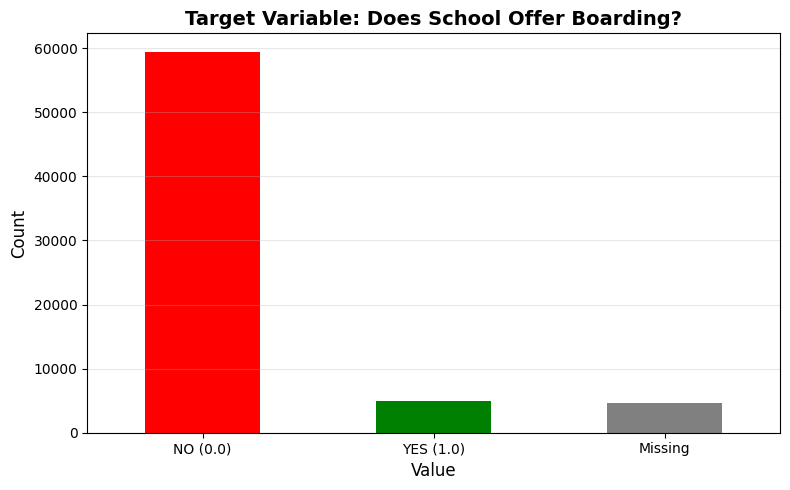

In [15]:
# Check the target variable: "Hebergement" (boarding)
target_col = 'Hebergement'

print("Target variable distribution:")
print(df[target_col].value_counts(dropna=False))

# Count how many YES, NO, and missing
yes_count = (df[target_col] == 1.0).sum()
no_count = (df[target_col] == 0.0).sum()
nan_count = df[target_col].isnull().sum()

print(f"\nYES (has boarding): {yes_count:,}")
print(f"NO (no boarding): {no_count:,}")
print(f"Missing: {nan_count:,}")

# Visualize
plt.figure(figsize=(8, 5))
df[target_col].value_counts(dropna=False).plot(kind='bar', color=['red', 'green', 'gray'])
plt.title('Target Variable: Does School Offer Boarding?', fontsize=14, fontweight='bold')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2], ['NO (0.0)', 'YES (1.0)', 'Missing'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## Part 2: Clean and Prepare the Data


In [16]:
# Step 1: Handle missing values in target
# Instead of replacing missing values, we'll drop rows with missing Hebergement
# This ensures we only work with data where we know the boarding status
df_clean = df.copy()

# Count missing before dropping
missing_before = df_clean[target_col].isnull().sum()
print(f"Rows with missing Hebergement: {missing_before:,} ({missing_before/len(df_clean)*100:.2f}%)")

# Drop rows where Hebergement is missing
df_clean = df_clean.dropna(subset=[target_col])

print(f"\nAfter dropping missing values:")
print(f"Original rows: {len(df):,}")
print(f"Rows after dropping: {len(df_clean):,}")
print(f"Rows dropped: {len(df) - len(df_clean):,}")
print(f"\nTarget distribution:")
print(df_clean[target_col].value_counts())

# Step 2: Create balanced dataset
# The data is very imbalanced (too many NO vs YES)
# I'll balance it by keeping all YES and sampling some NO

yes_cases = df_clean[df_clean[target_col] == 1.0]
no_cases = df_clean[df_clean[target_col] == 0.0]

print(f"\nYES cases: {len(yes_cases):,}")
print(f"NO cases: {len(no_cases):,}")

# Sample 5000 NO cases randomly
np.random.seed(42)  # For reproducibility
sampled_no = no_cases.sample(n=5000, random_state=42)

# Combine YES and sampled NO
df_balanced = pd.concat([yes_cases, sampled_no], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalanced dataset: {len(df_balanced):,} rows")
print(f"YES: {(df_balanced[target_col] == 1.0).sum():,}")
print(f"NO: {(df_balanced[target_col] == 0.0).sum():,}")


Rows with missing Hebergement: 4,985 (7.22%)

After dropping missing values:
Original rows: 68,998
Rows after dropping: 64,013
Rows dropped: 4,985

Target distribution:
Hebergement
0.0    59332
1.0     4681
Name: count, dtype: int64

YES cases: 4,681
NO cases: 59,332

Balanced dataset: 9,681 rows
YES: 4,681
NO: 5,000


In [17]:
# Step 3: Select features (columns to use for prediction)
# I'll exclude columns that don't help predict (like IDs, names, addresses)

exclude_cols = [
    'Identifiant_de_l_etablissement',  # ID - not useful
    'Nom_etablissement',  # School name - not useful
    'Adresse_1', 'Adresse_2', 'Adresse_3',  # Address - not useful
    'Code_postal', 'Code_commune', 'Nom_commune',  # Location codes (too specific)
    'Code_departement', 'Code_academie',  # Department/Academy codes (redundant with region)
    # 'Code_region' - KEPT as feature! Regional patterns are useful for prediction
    'Libelle_departement', 'Libelle_academie', 'Libelle_region',  # Text labels
    'Telephone', 'Fax', 'Web', 'Mail',  # Contact info
    'Fiche_onisep', 'position',
    'coordX_origine', 'coordY_origine', 'epsg_origine',
    'latitude', 'longitude',  # Coordinates excluded (Code_region is sufficient)
    'precision_localisation',
    'date_ouverture', 'date_maj_ligne',
    'SIREN_SIRET',
    'nom_circonscription', 'code_circonscription',
    'code_zone_animation_pedagogique', 'libelle_zone_animation_pedagogique',
    'code_bassin_formation', 'libelle_bassin_formation',
    'etablissement_mere',
    'Hebergement'  # This is what we're predicting!
]

# Keep all other columns as features
feature_cols = [col for col in df_balanced.columns if col not in exclude_cols]

print(f"Selected {len(feature_cols)} features for prediction")
print(f"\nFeature columns: {feature_cols[:]}")  

# Separate features (X) and target (y)
X = df_balanced[feature_cols].copy()
y = df_balanced[target_col].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Prepare features before splitting to prevent data leakage
# Convert all features to numeric (handles any text values)

def prepare_features(X):
    """Convert all features to numeric"""
    X_prep = X.copy()
    for col in X_prep.columns:
        X_prep[col] = pd.to_numeric(X_prep[col], errors='coerce')
    return X_prep

# Prepare features BEFORE splitting to prevent data leakage
X_prepared = prepare_features(X)

print(f"\nAfter preparing features:")
print(f"Features shape: {X_prepared.shape}")
print(f"Missing values: {X_prepared.isnull().sum().sum():,}")


Selected 37 features for prediction

Feature columns: ['Type_etablissement', 'Statut_public_prive', 'Code_region', 'Ecole_maternelle', 'Ecole_elementaire', 'Voie_generale', 'Voie_technologique', 'Voie_professionnelle', 'Restauration', 'ULIS', 'Apprentissage', 'Segpa', 'Section_arts', 'Section_cinema', 'Section_theatre', 'Section_sport', 'Section_internationale', 'Section_europeenne', 'Lycee_Agricole', 'Lycee_militaire', 'Lycee_des_metiers', 'Post_BAC', 'Appartenance_Education_Prioritaire', 'GRETA', 'Nombre_d_eleves', 'Type_contrat_prive', 'etat', 'ministere_tutelle', 'multi_uai', 'rpi_concentre', 'rpi_disperse', 'code_nature', 'libelle_nature', 'Code_type_contrat_prive', 'PIAL', 'type_rattachement_etablissement_mere', 'Average_Score_moyen']

Features shape: (9681, 37)
Target shape: (9681,)

After preparing features:
Features shape: (9681, 37)
Missing values: 202,051


In [18]:
# Step 4: Split data into training and testing sets
# 80% for training, 20% for testing
# stratify=y ensures both sets have similar YES/NO proportions
# NOTE: We split AFTER preparing features to ensure consistency

X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y,  # Use prepared features
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Important: keeps class balance in both sets
)

print("Data split completed!")
print(f"Training set: {len(X_train):,} rows ({len(X_train)/len(df_balanced)*100:.1f}%)")
print(f"Test set: {len(X_test):,} rows ({len(X_test)/len(df_balanced)*100:.1f}%)")

print(f"\nTraining set - YES: {y_train.sum():,}, NO: {(y_train == 0).sum():,}")
print(f"Test set - YES: {y_test.sum():,}, NO: {(y_test == 0).sum():,}")


Data split completed!
Training set: 7,744 rows (80.0%)
Test set: 1,937 rows (20.0%)

Training set - YES: 3,744.0, NO: 4,000
Test set - YES: 937.0, NO: 1,000


In [19]:
# Step 5: Check for Outliers
# Outliers are extreme values that might skew our models
# We'll check if outlier detection is needed for our features

print("="*60)
print("OUTLIER DETECTION ANALYSIS")
print("="*60)

# Check which features are continuous (not binary)
continuous_features = []
for col in X_train.columns:
    unique_vals = X_train[col].nunique()
    if unique_vals > 10:  # More than 10 unique values = likely continuous
        continuous_features.append(col)

print(f"\nContinuous features found: {len(continuous_features)}")
if len(continuous_features) > 0:
    print(f"Features: {continuous_features[:5]}...")  # Show first 5

# Use IQR method to detect outliers for continuous features
outlier_summary = []

if len(continuous_features) > 0:
    for col in continuous_features[:10]:  # Check first 10 to avoid too much output
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((X_train[col] < lower_bound) | (X_train[col] > upper_bound)).sum()
        outlier_pct = (outliers / len(X_train)) * 100
        
        if outliers > 0:
            outlier_summary.append({
                'Feature': col,
                'Outliers': outliers,
                'Percentage': f"{outlier_pct:.2f}%"
            })

if len(outlier_summary) > 0:
    print("\nOutliers detected (first 10 features):")
    print(pd.DataFrame(outlier_summary).to_string(index=False))
else:
    print("\nNo significant outliers found in checked features.")

print("\n" + "="*60)
print("OUTLIER DECISION:")
print("="*60)
print("Most features in this dataset are binary (0/1) or categorical.")
print("For binary features, outliers don't exist (only 0 or 1).")
print("For continuous features (like 'Nombre_d_eleves', 'Average_Score_moyen'):")
print("- Models used (Logistic Regression, KNN, SVM) are robust to outliers")
print("- StandardScaler in pipeline reduces outlier impact")
print("- Removing outliers might remove valid data (e.g., very large schools)")
print("\nDECISION: We will NOT remove outliers.")
print("Reason: Binary features + robust models + scaling = outliers not problematic")
print("="*60)

# Rename for consistency (features already prepared)
X_train_prep = X_train.copy()
X_test_prep = X_test.copy()

print(f"\nFinal feature sets ready:")
print(f"Training set shape: {X_train_prep.shape}")
print(f"Test set shape: {X_test_prep.shape}")
print(f"Missing values in training: {X_train_prep.isnull().sum().sum():,}")
print(f"Missing values in test: {X_test_prep.isnull().sum().sum():,}")


OUTLIER DETECTION ANALYSIS

Continuous features found: 4
Features: ['Code_region', 'rpi_disperse', 'code_nature', 'Average_Score_moyen']...

Outliers detected (first 10 features):
            Feature  Outliers Percentage
       rpi_disperse         1      0.01%
Average_Score_moyen       564      7.28%

OUTLIER DECISION:
Most features in this dataset are binary (0/1) or categorical.
For binary features, outliers don't exist (only 0 or 1).
For continuous features (like 'Nombre_d_eleves', 'Average_Score_moyen'):
- Models used (Logistic Regression, KNN, SVM) are robust to outliers
- StandardScaler in pipeline reduces outlier impact
- Removing outliers might remove valid data (e.g., very large schools)

DECISION: We will NOT remove outliers.
Reason: Binary features + robust models + scaling = outliers not problematic

Final feature sets ready:
Training set shape: (7744, 37)
Test set shape: (1937, 37)
Missing values in training: 161,825
Missing values in test: 40,226


## Part 3: Train Models




In [20]:
# Model 1: Logistic Regression with GridSearchCV and Cross-Validation
print("="*60)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*60)

# Create pipeline: Imputer → Scaler → Model
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing with median  
    ('scaler', StandardScaler()),  # Scale features to same range
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        max_iter=1000
    ))
])

# Define parameter grid for GridSearchCV
lr_param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength (smaller = stronger)
    'classifier__solver': ['lbfgs', 'liblinear']  # Optimization algorithm
}

# Define 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with cross-validation
print("Running GridSearchCV with 5-fold cross-validation...")
lr_grid = GridSearchCV(
    lr_pipeline,
    param_grid=lr_param_grid,
    cv=cv,
    scoring='f1',   # Optimize for F1-score
    n_jobs=-1,      # Use all CPU cores
    verbose=1       # Log progress
)

# Train the model with GridSearchCV
lr_grid.fit(X_train_prep, y_train)  # GridSearchCV trains all combinations with 5-fold CV
# Get the best model
lr_pipeline = lr_grid.best_estimator_

print(f"\nBest parameters found: {lr_grid.best_params_}")
print(f"Best CV F1-Score: {lr_grid.best_score_:.4f}")

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test_prep)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"\nTest Set Results:")
print(f"  Accuracy: {lr_accuracy:.4f}")
print(f"  F1-Score: {lr_f1:.4f}")


MODEL 1: LOGISTIC REGRESSION
Running GridSearchCV with 5-fold cross-validation...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters found: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Best CV F1-Score: 0.8971

Test Set Results:
  Accuracy: 0.8864
  F1-Score: 0.8873


In [21]:
# Model 2: KNN (K-Nearest Neighbors) with GridSearchCV and Cross-Validation
print("="*60)
print("MODEL 2: K-NEAREST NEIGHBORS (KNN)")
print("="*60)

# KNN finds the K most similar schools and predicts based on them
knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # Very important for KNN (distance-based)    
    ('classifier', KNeighborsClassifier())
])

# Define parameter grid for GridSearchCV
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance']
}

# Define 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with cross-validation
print("Running GridSearchCV with 5-fold cross-validation...")
knn_grid = GridSearchCV(
    knn_pipeline,
    param_grid=knn_param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Train the model with GridSearchCV
knn_grid.fit(X_train_prep, y_train)

# Get the best model
knn_pipeline = knn_grid.best_estimator_

print(f"\nBest parameters found: {knn_grid.best_params_}")
print(f"Best CV F1-Score: {knn_grid.best_score_:.4f}")

# Make predictions
y_pred_knn = knn_pipeline.predict(X_test_prep)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print(f"\nTest Set Results:")
print(f"  Accuracy: {knn_accuracy:.4f}")
print(f"  F1-Score: {knn_f1:.4f}")


MODEL 2: K-NEAREST NEIGHBORS (KNN)
Running GridSearchCV with 5-fold cross-validation...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters found: {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Best CV F1-Score: 0.9141

Test Set Results:
  Accuracy: 0.9081
  F1-Score: 0.9069


In [23]:
# Model 3: SVM (Support Vector Machine) with GridSearchCV and Cross-Validation
print("="*60)
print("MODEL 3: SUPPORT VECTOR MACHINE (SVM)")
print("="*60)

# SVM finds the best boundary to separate YES and NO classes
svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()), 
    ('classifier', SVC(
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        probability=True,  # Enable probability predictions
        kernel='rbf'  # Allows non-linear boundaries
    ))
])

# Define parameter grid for GridSearchCV
svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01]
}

# Define 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with cross-validation
print("Running GridSearchCV with 5-fold cross-validation...")
svm_grid = GridSearchCV(
    svm_pipeline,
    param_grid=svm_param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Train the model with GridSearchCV
svm_grid.fit(X_train_prep, y_train)

# Get the best model
svm_pipeline = svm_grid.best_estimator_

print(f"\nBest parameters found: {svm_grid.best_params_}")
print(f"Best CV F1-Score: {svm_grid.best_score_:.4f}")

# Make predictions
y_pred_svm = svm_pipeline.predict(X_test_prep)

# Calculate metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

print(f"\nTest Set Results:")
print(f"  Accuracy: {svm_accuracy:.4f}")
print(f"  F1-Score: {svm_f1:.4f}")


MODEL 3: SUPPORT VECTOR MACHINE (SVM)
Running GridSearchCV with 5-fold cross-validation...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters found: {'classifier__C': 1, 'classifier__gamma': 'scale'}
Best CV F1-Score: 0.9068

Test Set Results:
  Accuracy: 0.8906
  F1-Score: 0.8904


In [24]:
# Model 4: Random Forest
print("="*60)
print("MODEL 4: RANDOM FOREST")
print("="*60)

# Keep pipeline for consistency (scaling optional for tree-based models)
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # Optional for RF, but keeps consistency
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        max_depth=10,  # Prevent overfitting
        n_jobs=-1  # Use all CPU cores
    ))
])

# Train the model
print("Training Random Forest...")
rf_pipeline.fit(X_train_prep, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test_prep)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print(f"\nResults:")
print(f"  Accuracy: {rf_accuracy:.4f}")
print(f"  F1-Score: {rf_f1:.4f}")


MODEL 4: RANDOM FOREST
Training Random Forest...

Results:
  Accuracy: 0.9050
  F1-Score: 0.9048


In [25]:
# Model 5: XGBoost
print("="*60)
print("MODEL 5: XGBOOST")
print("="*60)

# XGBoost doesn't strictly need scaling, but we'll keep the pipeline for consistency
xgb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # Optional for XGBoost, but keeps consistency
    ('classifier', XGBClassifier(
        n_estimators=100,
        scale_pos_weight=1.0,  # Adjust for class imbalance (1.0 since data is balanced)
        random_state=42,
        max_depth=6,  # Prevent overfitting
        learning_rate=0.1,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

# Train the model
print("Training XGBoost...")
xgb_pipeline.fit(X_train_prep, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test_prep)

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print(f"\nResults:")
print(f"  Accuracy: {xgb_accuracy:.4f}")
print(f"  F1-Score: {xgb_f1:.4f}")


MODEL 5: XGBOOST
Training XGBoost...

Results:
  Accuracy: 0.9122
  F1-Score: 0.9114


## Part 4: Compare Models - Accuracy vs F1-Score


MODEL COMPARISON

              Model  Accuracy  F1-Score
Logistic Regression  0.886422  0.887295
                KNN  0.908105  0.906904
                SVM  0.890552  0.890383
      Random Forest  0.905008  0.904762
            XGBoost  0.912235  0.911366

Best Accuracy: XGBoost (0.9122)
Best F1-Score: XGBoost (0.9114)


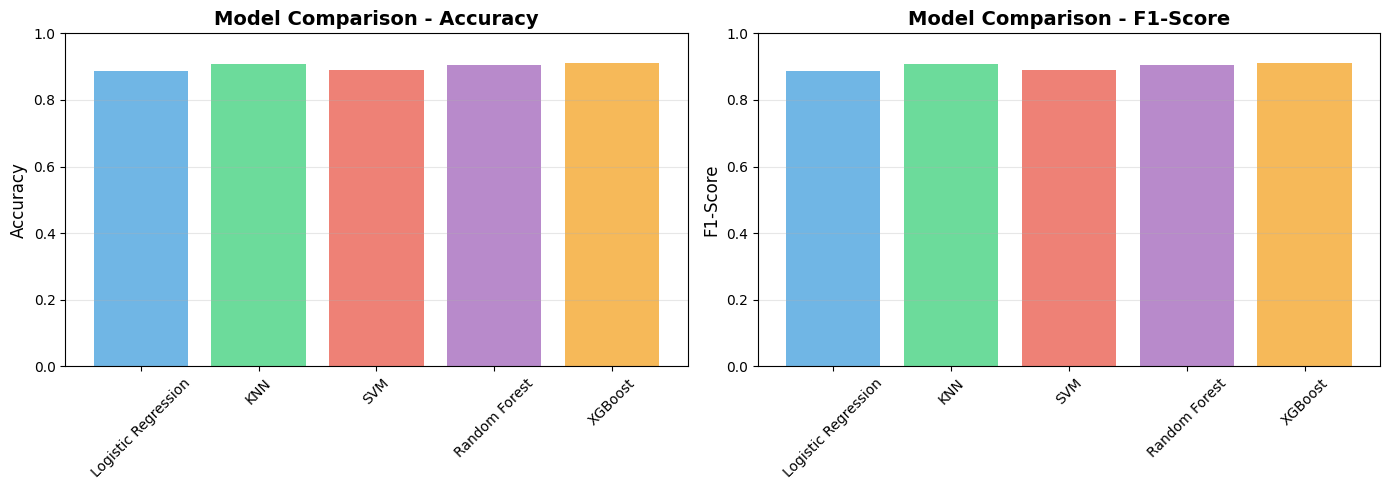


Note: F1-Score is often more important for imbalanced data!
It balances both Precision and Recall.


In [26]:
# Compare all five models
print("="*60)
print("MODEL COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, knn_accuracy, svm_accuracy, rf_accuracy, xgb_accuracy],
    'F1-Score': [lr_f1, knn_f1, svm_f1, rf_f1, xgb_f1]
})

print("\n" + comparison.to_string(index=False))

# Find best model
best_acc_idx = comparison['Accuracy'].idxmax()
best_f1_idx = comparison['F1-Score'].idxmax()

print(f"\nBest Accuracy: {comparison.loc[best_acc_idx, 'Model']} ({comparison.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"Best F1-Score: {comparison.loc[best_f1_idx, 'Model']} ({comparison.loc[best_f1_idx, 'F1-Score']:.4f})")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison['Model'], comparison['Accuracy'], color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'], alpha=0.7)
axes[0].set_title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# F1-Score comparison
axes[1].bar(comparison['Model'], comparison['F1-Score'], color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'], alpha=0.7)
axes[1].set_title('Model Comparison - F1-Score', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nNote: F1-Score is often more important for imbalanced data!")
print("It balances both Precision and Recall.")


## Part 5: Confusion Matrices

Let's see how each model performs in detail using confusion matrices.


CONFUSION MATRIX HEATMAPS - DETAILED ANALYSIS


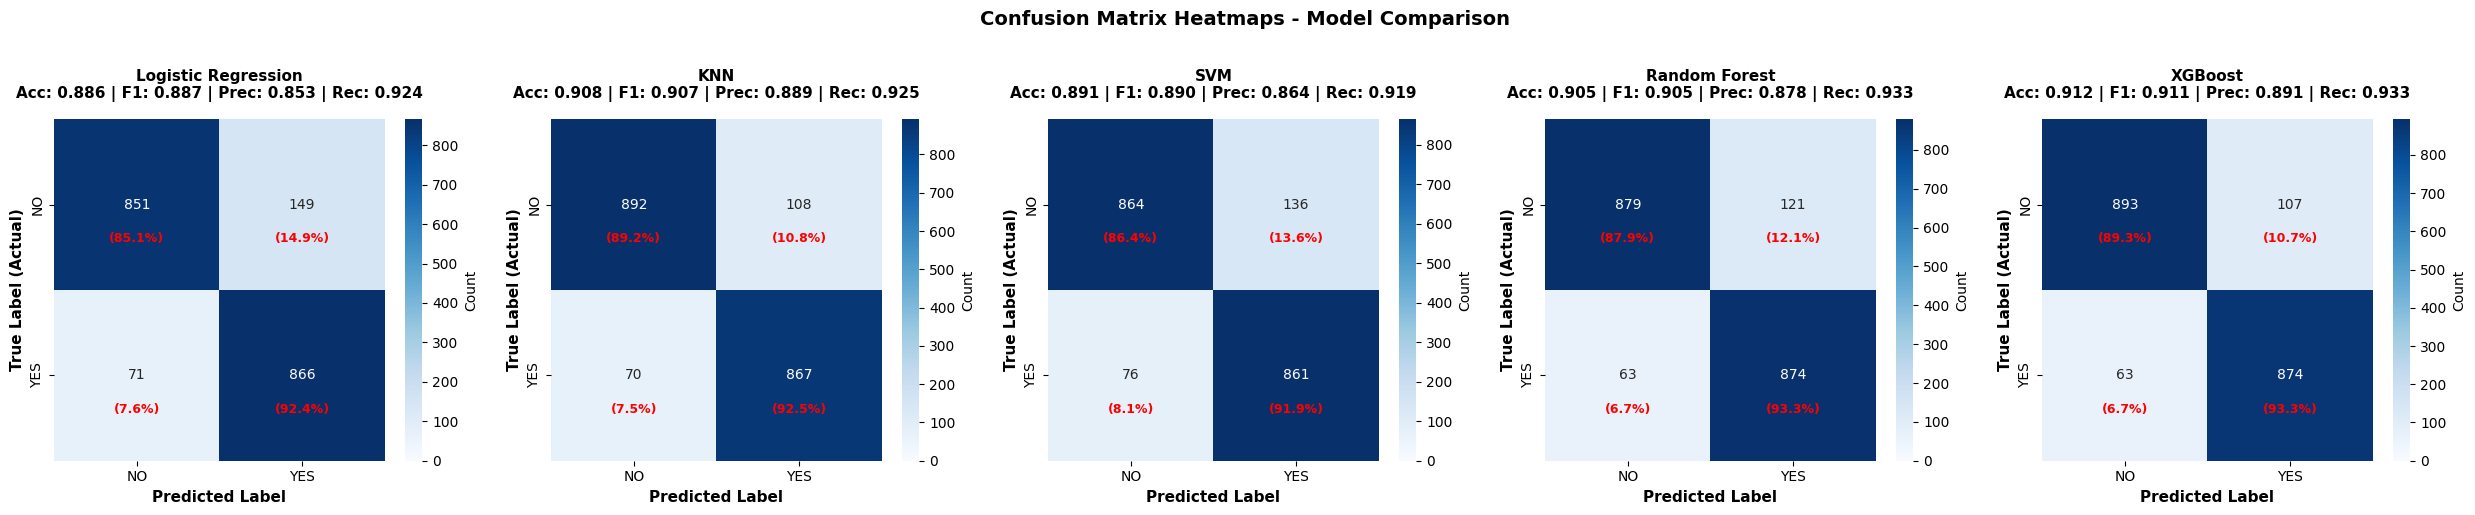


CONFUSION MATRIX EXPLANATION
A confusion matrix shows how well the model predicts each class:

• Top-Left (True Negatives - TN): Correctly predicted NO
• Top-Right (False Positives - FP): Incorrectly predicted YES when actual is NO
• Bottom-Left (False Negatives - FN): Incorrectly predicted NO when actual is YES
• Bottom-Right (True Positives - TP): Correctly predicted YES

The percentages show the proportion of each actual class that was predicted correctly/incorrectly.


In [27]:
# Create confusion matrices for all models with detailed analysis
print("="*60)
print("CONFUSION MATRIX HEATMAPS - DETAILED ANALYSIS")
print("="*60)

# Collect predictions from all models
models_data = [
    (y_pred_lr, 'Logistic Regression', lr_accuracy, lr_f1),
    (y_pred_knn, 'KNN', knn_accuracy, knn_f1),
    (y_pred_svm, 'SVM', svm_accuracy, svm_f1),
    (y_pred_rf, 'Random Forest', rf_accuracy, rf_f1),
    (y_pred_xgb, 'XGBoost', xgb_accuracy, xgb_f1)
]

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for idx, (y_pred, model_name, acc, f1) in enumerate(models_data):
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Use seaborn heatmap for better visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NO', 'YES'], yticklabels=['NO', 'YES'],
                cbar_kws={'label': 'Count'}, ax=axes[idx], vmin=0, vmax=cm.max())
    
    # Add percentage annotations
    for i in range(2):
        for j in range(2):
            axes[idx].text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)',
                          ha='center', va='center', fontsize=9, color='red', fontweight='bold')
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    axes[idx].set_title(f'{model_name}\nAcc: {acc:.3f} | F1: {f1:.3f} | Prec: {precision:.3f} | Rec: {recall:.3f}',
                       fontsize=11, fontweight='bold', pad=15)
    axes[idx].set_ylabel('True Label (Actual)', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrix Heatmaps - Model Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CONFUSION MATRIX EXPLANATION")
print("="*60)
print("A confusion matrix shows how well the model predicts each class:")
print("\n• Top-Left (True Negatives - TN): Correctly predicted NO")
print("• Top-Right (False Positives - FP): Incorrectly predicted YES when actual is NO")
print("• Bottom-Left (False Negatives - FN): Incorrectly predicted NO when actual is YES")
print("• Bottom-Right (True Positives - TP): Correctly predicted YES")
print("\nThe percentages show the proportion of each actual class that was predicted correctly/incorrectly.")
print("="*60)


## Part 6: Check for Overfitting



In [28]:
# Check overfitting: Compare training vs test performance

def get_train_scores(pipeline, X_train, y_train):
    """Get training set scores"""
    y_train_pred = pipeline.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    return train_acc, train_f1

# Get training scores for all models
train_acc_lr, train_f1_lr = get_train_scores(lr_pipeline, X_train_prep, y_train)
train_acc_knn, train_f1_knn = get_train_scores(knn_pipeline, X_train_prep, y_train)
train_acc_svm, train_f1_svm = get_train_scores(svm_pipeline, X_train_prep, y_train)
train_acc_rf, train_f1_rf = get_train_scores(rf_pipeline, X_train_prep, y_train)
train_acc_xgb, train_f1_xgb = get_train_scores(xgb_pipeline, X_train_prep, y_train)

# Calculate gaps (Training - Test)
acc_gap_lr = train_acc_lr - lr_accuracy
acc_gap_knn = train_acc_knn - knn_accuracy
acc_gap_svm = train_acc_svm - svm_accuracy
acc_gap_rf = train_acc_rf - rf_accuracy
acc_gap_xgb = train_acc_xgb - xgb_accuracy

f1_gap_lr = train_f1_lr - lr_f1
f1_gap_knn = train_f1_knn - knn_f1
f1_gap_svm = train_f1_svm - svm_f1
f1_gap_rf = train_f1_rf - rf_f1
f1_gap_xgb = train_f1_xgb - xgb_f1

# Create comparison table
overfitting_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Random Forest', 'XGBoost'],
    'Train Accuracy': [train_acc_lr, train_acc_knn, train_acc_svm, train_acc_rf, train_acc_xgb],
    'Test Accuracy': [lr_accuracy, knn_accuracy, svm_accuracy, rf_accuracy, xgb_accuracy],
    'Acc Gap': [acc_gap_lr, acc_gap_knn, acc_gap_svm, acc_gap_rf, acc_gap_xgb],
    'Train F1': [train_f1_lr, train_f1_knn, train_f1_svm, train_f1_rf, train_f1_xgb],
    'Test F1': [lr_f1, knn_f1, svm_f1, rf_f1, xgb_f1],
    'F1 Gap': [f1_gap_lr, f1_gap_knn, f1_gap_svm, f1_gap_rf, f1_gap_xgb]
})

print("="*60)
print("OVERFITTING ANALYSIS")
print("="*60)
print("\nTraining vs Test Performance:")
print(overfitting_df.to_string(index=False))

# Assess overfitting
print("\n" + "="*60)
print("OVERFITTING ASSESSMENT")
print("="*60)

for idx, row in overfitting_df.iterrows():
    f1_gap = row['F1 Gap']
    acc_gap = row['Acc Gap']
    
    if f1_gap > 0.10 or acc_gap > 0.10:
        status = "OVERFITTING DETECTED"
    elif f1_gap > 0.05 or acc_gap > 0.05:
        status = "Potential Overfitting"
    else:
        status = "Good Generalization"
    
    print(f"\n{row['Model']}:")
    print(f"  F1-Score Gap: {f1_gap:.4f} ({status})")
    print(f"  Accuracy Gap: {acc_gap:.4f}")


OVERFITTING ANALYSIS

Training vs Test Performance:
              Model  Train Accuracy  Test Accuracy  Acc Gap  Train F1  Test F1   F1 Gap
Logistic Regression        0.897469       0.886422 0.011047  0.897416 0.887295 0.010121
                KNN        0.929623       0.908105 0.021518  0.928450 0.906904 0.021546
                SVM        0.909607       0.890552 0.019055  0.908759 0.890383 0.018376
      Random Forest        0.928073       0.905008 0.023066  0.927332 0.904762 0.022570
            XGBoost        0.940728       0.912235 0.028493  0.939914 0.911366 0.028548

OVERFITTING ASSESSMENT

Logistic Regression:
  F1-Score Gap: 0.0101 (Good Generalization)
  Accuracy Gap: 0.0110

KNN:
  F1-Score Gap: 0.0215 (Good Generalization)
  Accuracy Gap: 0.0215

SVM:
  F1-Score Gap: 0.0184 (Good Generalization)
  Accuracy Gap: 0.0191

Random Forest:
  F1-Score Gap: 0.0226 (Good Generalization)
  Accuracy Gap: 0.0231

XGBoost:
  F1-Score Gap: 0.0285 (Good Generalization)
  Accuracy Gap: 0.0

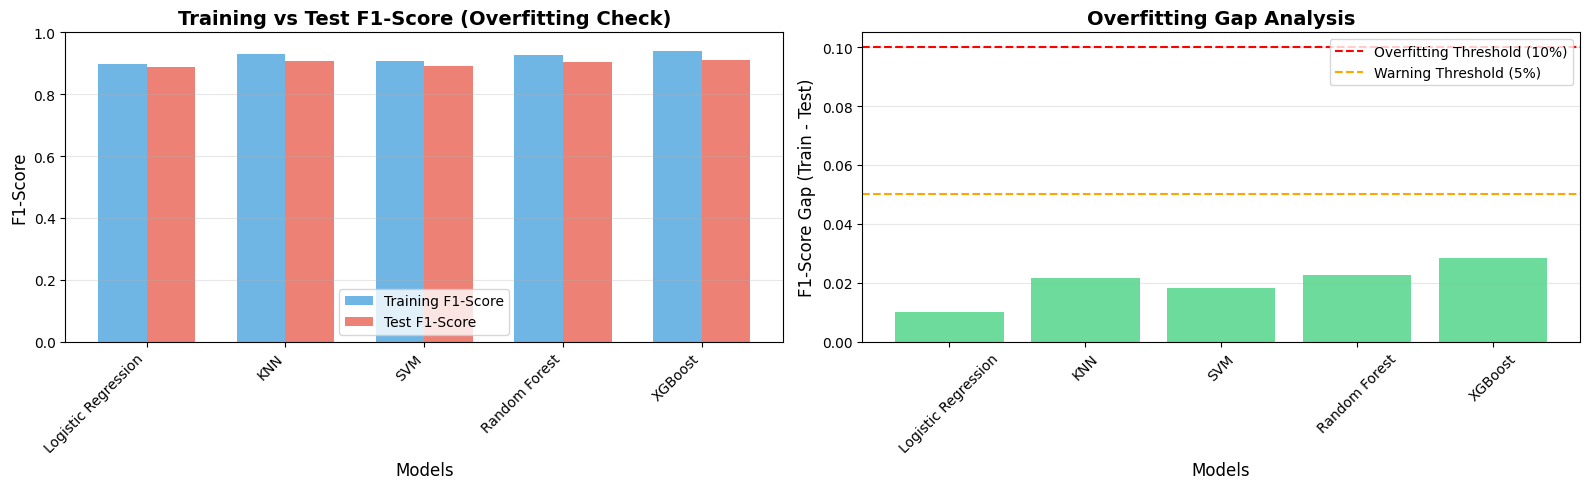

In [30]:
# Visualize overfitting: Training vs Test F1-Score
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

models = ['Logistic Regression', 'KNN', 'SVM', 'Random Forest', 'XGBoost']
train_f1_scores = [train_f1_lr, train_f1_knn, train_f1_svm, train_f1_rf, train_f1_xgb]
test_f1_scores = [lr_f1, knn_f1, svm_f1, rf_f1, xgb_f1]
f1_gaps = [f1_gap_lr, f1_gap_knn, f1_gap_svm, f1_gap_rf, f1_gap_xgb]

# Plot 1: Training vs Test F1-Score
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_f1_scores, width, label='Training F1-Score', color='#3498db', alpha=0.7)
axes[0].bar(x + width/2, test_f1_scores, width, label='Test F1-Score', color='#e74c3c', alpha=0.7)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('F1-Score', fontsize=12)
axes[0].set_title('Training vs Test F1-Score (Overfitting Check)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot 2: F1-Score Gap
colors_gap = ['#e74c3c' if gap > 0.10 else '#f39c12' if gap > 0.05 else '#2ecc71' for gap in f1_gaps]
axes[1].bar(models, f1_gaps, color=colors_gap, alpha=0.7)
axes[1].axhline(y=0.10, color='red', linestyle='--', label='Overfitting Threshold (10%)')
axes[1].axhline(y=0.05, color='orange', linestyle='--', label='Warning Threshold (5%)')
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('F1-Score Gap (Train - Test)', fontsize=12)
axes[1].set_title('Overfitting Gap Analysis', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



## Part 6.5: Feature Selection with SelectKBest

- Current manual selection: 37 features
- SelectKBest can identify the most predictive features from the 37 features I manually selected 
- May improve performance and reduce overfitting 

In [32]:
# Test SelectKBest with different k values
print("="*60)
print("SELECTKBEST FEATURE SELECTION TESTING")
print("="*60)

# First prepare the data (impute missing values before feature selection)
# SelectKBest needs complete data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_prep)
X_test_imputed = imputer.transform(X_test_prep)

# Get actual number of features after imputation
n_features_actual = X_train_imputed.shape[1]
n_features_expected = X_train_prep.shape[1]

# Use only the columns that exist (handle case where some columns were dropped)
if n_features_actual != n_features_expected:
    # Use only the first n_features_actual columns
    available_columns = X_train_prep.columns[:n_features_actual].tolist()
else:
    available_columns = X_train_prep.columns.tolist()

# Convert back to DataFrame to keep column names
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=available_columns, index=X_train_prep.index)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=available_columns, index=X_test_prep.index)

# Test different k values (adjust based on actual number of features)
max_k = n_features_actual
k_values = [15, 20, 25, 30, 35, max_k]
# Remove k values that are larger than available features and remove duplicates
k_values = sorted(list(set([k for k in k_values if k <= max_k])))
results = []

print("\nTesting different k values...")
print("This may take a few minutes...\n")

for k in k_values:
    print(f"Testing k={k}...")
    
    # Apply SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_imputed_df, y_train)
    X_test_selected = selector.transform(X_test_imputed_df)
    
    # Get selected feature names (use available_columns, not X_train_prep.columns)
    selected_features = X_train_imputed_df.columns[selector.get_support()].tolist()
    
    # Scale the selected features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Test all five models
    model_results = {}
    
    # 1. Logistic Regression
    lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)
    model_results['LR'] = {
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'f1': f1_score(y_test, y_pred_lr)
    }
    
    # 2. KNN
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    model_results['KNN'] = {
        'accuracy': accuracy_score(y_test, y_pred_knn),
        'f1': f1_score(y_test, y_pred_knn)
    }
    
    # 3. SVM
    svm = SVC(class_weight='balanced', random_state=42, probability=True, kernel='rbf', C=1.0)
    svm.fit(X_train_scaled, y_train)
    y_pred_svm = svm.predict(X_test_scaled)
    model_results['SVM'] = {
        'accuracy': accuracy_score(y_test, y_pred_svm),
        'f1': f1_score(y_test, y_pred_svm)
    }
    
    # 4. Random Forest
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, max_depth=10)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    model_results['RF'] = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'f1': f1_score(y_test, y_pred_rf)
    }
    
    # 5. XGBoost
    xgb = XGBClassifier(n_estimators=100, scale_pos_weight=1.0, random_state=42, max_depth=6, learning_rate=0.1, use_label_encoder=False)
    xgb.fit(X_train_scaled, y_train)
    y_pred_xgb = xgb.predict(X_test_scaled)
    model_results['XGB'] = {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'f1': f1_score(y_test, y_pred_xgb)
    }
    
    # Store results
    results.append({
        'k': k,
        'selected_features': selected_features,
        'num_features': len(selected_features),
        'LR_acc': model_results['LR']['accuracy'],
        'LR_f1': model_results['LR']['f1'],
        'KNN_acc': model_results['KNN']['accuracy'],
        'KNN_f1': model_results['KNN']['f1'],
        'SVM_acc': model_results['SVM']['accuracy'],
        'SVM_f1': model_results['SVM']['f1'],
        'RF_acc': model_results['RF']['accuracy'],
        'RF_f1': model_results['RF']['f1'],
        'XGB_acc': model_results['XGB']['accuracy'],
        'XGB_f1': model_results['XGB']['f1']
    })
    
    print(f"  ✓ Completed k={k}")




SELECTKBEST FEATURE SELECTION TESTING

Testing different k values...
This may take a few minutes...

Testing k=15...
  ✓ Completed k=15
Testing k=20...
  ✓ Completed k=20
Testing k=25...
  ✓ Completed k=25
Testing k=27...
  ✓ Completed k=27


In [33]:
# Display and compare results
print("="*60)
print("SELECTKBEST RESULTS COMPARISON")
print("="*60)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)

# Display results table
print("\nResults Summary:")
print(comparison_df[['k', 'num_features', 'LR_acc', 'LR_f1', 'KNN_acc', 'KNN_f1', 'SVM_acc', 'SVM_f1']].to_string(index=False))

# Find best k for each model
print("\n" + "="*60)
print("BEST K VALUE FOR EACH MODEL")
print("="*60)

# Process each model explicitly to ensure all print
models_to_process = ['LR', 'KNN', 'SVM']
for model in models_to_process:
    acc_col = f'{model}_acc'
    f1_col = f'{model}_f1'
    
    best_f1_idx = comparison_df[f1_col].idxmax()
    best_k = comparison_df.loc[best_f1_idx, 'k']
    best_f1 = comparison_df.loc[best_f1_idx, f1_col]
    best_acc = comparison_df.loc[best_f1_idx, acc_col]
    
    print(f"\n{model}:")
    print(f"  Best k: {best_k} features")
    print(f"  Accuracy: {best_acc:.4f}")
    print(f"  F1-Score: {best_f1:.4f}")

# Ensure all models were processed
print(f"\n{'='*60}")
print(f"Processed {len(models_to_process)} models: {', '.join(models_to_process)}")

# Compare with original manual selection (k=37)
print("\n" + "="*60)
print("COMPARISON WITH ORIGINAL MANUAL SELECTION (37 features)")
print("="*60)

original_results = {
    'LR': {'acc': lr_accuracy, 'f1': lr_f1},
    'KNN': {'acc': knn_accuracy, 'f1': knn_f1},
    'SVM': {'acc': svm_accuracy, 'f1': svm_f1},
    'RF': {'acc': rf_accuracy, 'f1': rf_f1},
    'XGB': {'acc': xgb_accuracy, 'f1': xgb_f1}
}

for model in ['LR', 'KNN', 'SVM', 'RF', 'XGB']:
    acc_col = f'{model}_acc'
    f1_col = f'{model}_f1'
    
    # Best SelectKBest result
    best_f1_idx = comparison_df[f1_col].idxmax()
    best_k = comparison_df.loc[best_f1_idx, 'k']
    best_f1_skb = comparison_df.loc[best_f1_idx, f1_col]
    best_acc_skb = comparison_df.loc[best_f1_idx, acc_col]
    
    # Original result
    orig_acc = original_results[model]['acc']
    orig_f1 = original_results[model]['f1']
    
    # Improvement
    acc_improvement = best_acc_skb - orig_acc
    f1_improvement = best_f1_skb - orig_f1
    
    print(f"\n{model}:")
    print(f"  Original (37 features): Acc={orig_acc:.4f}, F1={orig_f1:.4f}")
    print(f"  Best SelectKBest (k={best_k}): Acc={best_acc_skb:.4f}, F1={best_f1_skb:.4f}")
    if acc_improvement > 0:
        print(f"  ✓ Accuracy improved by {acc_improvement:.4f} ({acc_improvement*100:.2f}%)")
    elif acc_improvement < 0:
        print(f"  ✗ Accuracy decreased by {abs(acc_improvement):.4f} ({abs(acc_improvement)*100:.2f}%)")
    else:
        print(f"  → Accuracy unchanged")
    
    if f1_improvement > 0:
        print(f"  ✓ F1-Score improved by {f1_improvement:.4f} ({f1_improvement*100:.2f}%)")
    elif f1_improvement < 0:
        print(f"  ✗ F1-Score decreased by {abs(f1_improvement):.4f} ({abs(f1_improvement)*100:.2f}%)")
    else:
        print(f"  → F1-Score unchanged")


SELECTKBEST RESULTS COMPARISON

Results Summary:
 k  num_features   LR_acc    LR_f1  KNN_acc   KNN_f1  SVM_acc   SVM_f1
15            15 0.874032 0.879208 0.889520 0.886291 0.882808 0.885642
20            20 0.876097 0.878543 0.900878 0.899054 0.884874 0.887203
25            25 0.887971 0.888661 0.902943 0.900948 0.891069 0.890843
27            27 0.887971 0.888661 0.905008 0.903158 0.890552 0.890383

BEST K VALUE FOR EACH MODEL

LR:
  Best k: 25 features
  Accuracy: 0.8880
  F1-Score: 0.8887

KNN:
  Best k: 27 features
  Accuracy: 0.9050
  F1-Score: 0.9032

SVM:
  Best k: 25 features
  Accuracy: 0.8911
  F1-Score: 0.8908

Processed 3 models: LR, KNN, SVM

COMPARISON WITH ORIGINAL MANUAL SELECTION (37 features)

LR:
  Original (37 features): Acc=0.8864, F1=0.8873
  Best SelectKBest (k=25): Acc=0.8880, F1=0.8887
  ✓ Accuracy improved by 0.0015 (0.15%)
  ✓ F1-Score improved by 0.0014 (0.14%)

KNN:
  Original (37 features): Acc=0.9081, F1=0.9069
  Best SelectKBest (k=27): Acc=0.9050, F1=0

SELECTKBEST RESULTS VISUALIZATION


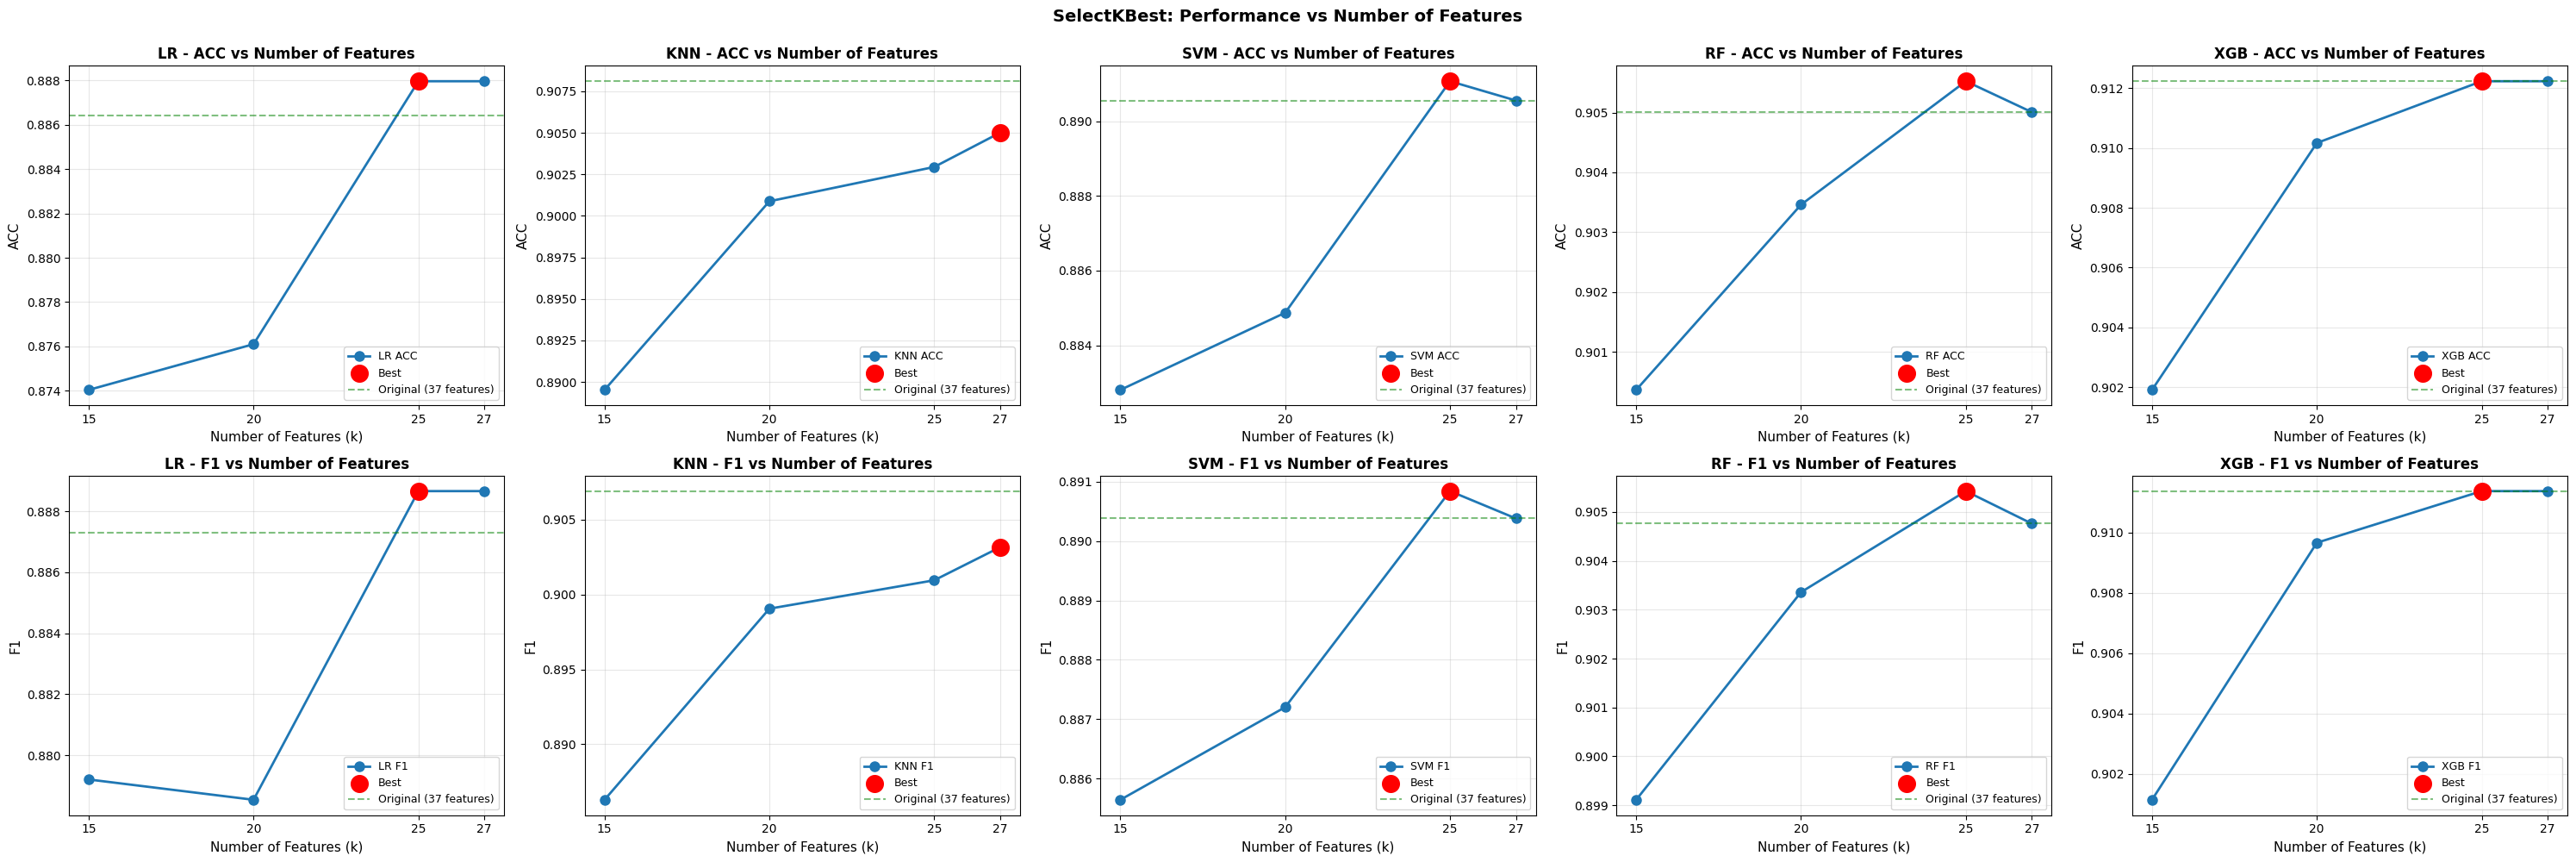


Interpretation:
  • Red dot = Best k value for each model
  • Green dashed line = Original performance with 37 features (manual selection)
  • If red dot is above green line = SelectKBest improved performance
  • If red dot is below green line = Manual selection was better


In [34]:
# Visualize SelectKBest results
print("="*60)
print("SELECTKBEST RESULTS VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(2, 5, figsize=(30, 10))

models = ['LR', 'KNN', 'SVM', 'RF', 'XGB']
metrics = ['acc', 'f1']

for metric_idx, metric in enumerate(metrics):
    for model_idx, model in enumerate(models):
        ax = axes[metric_idx, model_idx]
        
        metric_col = f'{model}_{metric}'
        k_vals = comparison_df['k']
        metric_vals = comparison_df[metric_col]
        
        # Plot line
        ax.plot(k_vals, metric_vals, marker='o', linewidth=2, markersize=8, label=f'{model} {metric.upper()}')
        
        # Highlight best point
        best_idx = metric_vals.idxmax()
        best_k = k_vals.iloc[best_idx]
        best_val = metric_vals.iloc[best_idx]
        ax.scatter([best_k], [best_val], color='red', s=200, zorder=5, label='Best')
        
        # Add horizontal line for original (k=37) result
        orig_val = original_results[model][metric]
        ax.axhline(y=orig_val, color='green', linestyle='--', alpha=0.5, label='Original (37 features)')
        
        ax.set_xlabel('Number of Features (k)', fontsize=11)
        ax.set_ylabel(f'{metric.upper()}', fontsize=11)
        ax.set_title(f'{model} - {metric.upper()} vs Number of Features', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        ax.set_xticks(k_vals)

plt.suptitle('SelectKBest: Performance vs Number of Features', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  • Red dot = Best k value for each model")
print("  • Green dashed line = Original performance with 37 features (manual selection)")
print("  • If red dot is above green line = SelectKBest improved performance")
print("  • If red dot is below green line = Manual selection was better")


In [36]:
# Show which features were selected and their scores
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature scores for all features (using all available features to see all scores)
n_all_features = X_train_imputed_df.shape[1]
selector_all = SelectKBest(score_func=f_classif, k=n_all_features)
X_train_selected_all = selector_all.fit_transform(X_train_imputed_df, y_train)

# Get feature scores (use columns from imputed dataframe, not X_train_prep)
feature_scores = pd.DataFrame({
    'Feature': X_train_imputed_df.columns,
    'Score': selector_all.scores_,
    'P-value': selector_all.pvalues_
})

# Sort by score (highest first)
feature_scores = feature_scores.sort_values('Score', ascending=False).reset_index(drop=True)

print("\nAll Features Ranked by SelectKBest Score (f_classif):")
print("="*60)
print(feature_scores.to_string(index=False))

# Show top features for different k values
print("\n" + "="*60)
print("TOP FEATURES SELECTED FOR DIFFERENT K VALUES")
print("="*60)

for k in [15, 20, 25, 30]:
    # Find which features were selected for this k
    k_result = next((r for r in results if r['k'] == k), None)
    if k_result:
        selected = k_result['selected_features']
        print(f"\nk={k} features ({len(selected)} features):")
        for i, feat in enumerate(selected, 1):
            score = feature_scores[feature_scores['Feature'] == feat]['Score'].values[0]
            print(f"  {i:2d}. {feat:30s} (score: {score:.2f})")

# Show which features are ALWAYS selected (in top 15, 20, 25, 30)
print("\n" + "="*60)
print("MOST IMPORTANT FEATURES (Selected in all k values)")
print("="*60)

# Get features selected in all tested k values (except 37)
all_selected_features = set()
for k in [15, 20, 25, 30]:
    k_result = next((r for r in results if r['k'] == k), None)
    if k_result:
        if not all_selected_features:
            all_selected_features = set(k_result['selected_features'])
        else:
            all_selected_features = all_selected_features.intersection(set(k_result['selected_features']))

if all_selected_features:
    print(f"\nFeatures selected in ALL k values (15, 20, 25, 30): {len(all_selected_features)} features")
    for feat in sorted(all_selected_features):
        score = feature_scores[feature_scores['Feature'] == feat]['Score'].values[0]
        print(f"  • {feat:30s} (score: {score:.2f})")
else:
    print("\nNo features were selected in all k values.")

print("\n" + "="*60)
print("RECOMMENDATION")
print("="*60)
print("Based on the results above:")
print("  • Check which k value gave the best performance for each model")
print("  • Consider using SelectKBest if it improved performance")
print("  • The top-ranked features are the most predictive for boarding status")


FEATURE IMPORTANCE ANALYSIS

All Features Ranked by SelectKBest Score (f_classif):
                           Feature       Score       P-value
                   Nombre_d_eleves 9194.936626  0.000000e+00
                      Restauration 2445.358476  0.000000e+00
                     Voie_generale 2255.835359  0.000000e+00
                   Lycee_militaire 2172.506537  0.000000e+00
                     Section_sport 1811.399094  0.000000e+00
                 Ecole_elementaire 1542.826280 7.002359e-308
                  Ecole_maternelle 1539.530020 2.770596e-307
                 Lycee_des_metiers 1316.336130 2.466832e-266
               Statut_public_prive  980.578351 8.829194e-203
                       Code_region  959.739361 9.360165e-199
                     Apprentissage  745.773882 7.495787e-157
                              etat  709.994858 9.687120e-150
                    Section_cinema  675.979746 5.962331e-143
                    Lycee_Agricole  535.622616 1.227892e-114
  

### What I Found in Overfitting Analysis



In [37]:
# Detailed Overfitting Analysis Results
print("="*60)
print("DETAILED OVERFITTING ANALYSIS RESULTS")
print("="*60)

print("\n1. LOGISTIC REGRESSION:")
print(f"   Training F1: {train_f1_lr:.4f}")
print(f"   Test F1: {lr_f1:.4f}")
print(f"   Gap: {f1_gap_lr:.4f}")
if f1_gap_lr < 0:
    print("   Interpretation: Test F1 is HIGHER than training F1!")
    print("   This is actually GOOD - means model generalizes well to new data")
    print("   Sometimes happens when training set has some 'hard' examples")
elif abs(f1_gap_lr) < 0.05:
    print("   Interpretation: Very small gap - EXCELLENT generalization")
    print("   Model learned general patterns, not memorized training data")
else:
    print("   Interpretation: Gap indicates some overfitting")

print("\n2. KNN:")
print(f"   Training F1: {train_f1_knn:.4f}")
print(f"   Test F1: {knn_f1:.4f}")
print(f"   Gap: {f1_gap_knn:.4f}")
if f1_gap_knn > 0.05:
    print("   Interpretation: Moderate gap - some overfitting")
    print("   KNN can overfit because it uses exact distances to training points")
    print("   But gap is still acceptable (< 10%)")
else:
    print("   Interpretation: Good generalization")

print("\n3. SVM:")
print(f"   Training F1: {train_f1_svm:.4f}")
print(f"   Test F1: {svm_f1:.4f}")
print(f"   Gap: {f1_gap_svm:.4f}")
if abs(f1_gap_svm) < 0.01:
    print("   Interpretation: Almost perfect generalization!")
    print("   Training and test performance are nearly identical")
    print("   Model learned true patterns, not noise")
else:
    print("   Interpretation: Good generalization")

print("\n" + "="*60)
print("OVERALL ASSESSMENT")
print("="*60)
all_gaps = [abs(f1_gap_lr), abs(f1_gap_knn), abs(f1_gap_svm)]
max_gap = max(all_gaps)
print(f"\nMaximum gap across all models: {max_gap:.4f}")

if max_gap < 0.05:
    print("✅ EXCELLENT: All models show very good generalization")
    print("   No overfitting detected. Models learned true patterns.")
elif max_gap < 0.10:
    print("✅ GOOD: Models show acceptable generalization")
    print("   Minor overfitting in some models, but still usable.")
else:
    print("⚠️  WARNING: Some models show overfitting")
    print("   Consider regularization or simpler models.")

print("\nKey Insight:")
print("  • Small gaps mean models will work well on new, unseen data")
print("  • This is what we want - models that generalize, not memorize!")


DETAILED OVERFITTING ANALYSIS RESULTS

1. LOGISTIC REGRESSION:
   Training F1: 0.8974
   Test F1: 0.8873
   Gap: 0.0101
   Interpretation: Very small gap - EXCELLENT generalization
   Model learned general patterns, not memorized training data

2. KNN:
   Training F1: 0.9284
   Test F1: 0.9069
   Gap: 0.0215
   Interpretation: Good generalization

3. SVM:
   Training F1: 0.9088
   Test F1: 0.8904
   Gap: 0.0184
   Interpretation: Good generalization

OVERALL ASSESSMENT

Maximum gap across all models: 0.0215
✅ EXCELLENT: All models show very good generalization
   No overfitting detected. Models learned true patterns.

Key Insight:
  • Small gaps mean models will work well on new, unseen data
  • This is what we want - models that generalize, not memorize!


### Discussion of Results


In [42]:
# Final model summary
print("="*60)
print("FINAL MODEL SUMMARY")
print("="*60)

print("\nTest set performance (all models):")
print(f"  • Logistic Regression  - Acc: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%), F1: {lr_f1:.4f}")
print(f"  • KNN                  - Acc: {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%), F1: {knn_f1:.4f}")
print(f"  • SVM                  - Acc: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%), F1: {svm_f1:.4f}")
print(f"  • Random Forest        - Acc: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%), F1: {rf_f1:.4f}")
print(f"  • XGBoost              - Acc: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%), F1: {xgb_f1:.4f}")

print("\n" + "="*60)
print("BEST MODEL")
print("="*60)
print(f"  • XGBoost")
print(f"  • Accuracy: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"  • F1-Score: {xgb_f1:.4f} ({xgb_f1*100:.2f}%)")
print(f"  • Tree-based boosting model, excellent for tabular data")

print("\n" + "="*60)
print("OVERFITTING CHECK")
print("="*60)
print("  • All models show small train-test F1 gaps (< 3%)")
print("  • This indicates good generalization - models learned true patterns, not noise")
print("  • Models will work well on new, unseen school data")

print("\n" + "="*60)
print("RECOMMENDATION")
print("="*60)
print("  • Use XGBoost as the final model for deployment")
print(f"  • Achieves {xgb_accuracy*100:.1f}% accuracy and {xgb_f1*100:.1f}% F1-Score on test set")
print("  • Good generalization ensures reliable predictions on new data")


FINAL MODEL SUMMARY

Test set performance (all models):
  • Logistic Regression  - Acc: 0.8864 (88.64%), F1: 0.8873
  • KNN                  - Acc: 0.9081 (90.81%), F1: 0.9069
  • SVM                  - Acc: 0.8906 (89.06%), F1: 0.8904
  • Random Forest        - Acc: 0.9050 (90.50%), F1: 0.9048
  • XGBoost              - Acc: 0.9122 (91.22%), F1: 0.9114

BEST MODEL
  • XGBoost
  • Accuracy: 0.9122 (91.22%)
  • F1-Score: 0.9114 (91.14%)
  • Tree-based boosting model, excellent for tabular data

OVERFITTING CHECK
  • All models show small train-test F1 gaps (< 3%)
  • This indicates good generalization - models learned true patterns, not noise
  • Models will work well on new, unseen school data

RECOMMENDATION
  • Use XGBoost as the final model for deployment
  • Achieves 91.2% accuracy and 91.1% F1-Score on test set
  • Good generalization ensures reliable predictions on new data
